In [1]:
# Core Libraries
import pandas as pd  # For creating and manipulating dataframes
import numpy as np  # For fast calculations
# Models
import statsmodels.api as sm  # For linear regression
import statsmodels.tsa as ts  # For time series analyses
from sklearn.ensemble import RandomForestRegressor  # Random Forest algorithm
import lightgbm as lgb  # Great gradient boosted trees algorithm written by microsoft
# Deep learning
import torch  # PyTorch library
import torch.nn as nn  # Module for creating neural networks
import torch.nn.functional as F  #
import torch.optim as opt


# Plotting
import matplotlib.pyplot as plt
plt.style.use('bmh')  # With this line you change the style of the plots so they're prettier
# The line below this comment allows you to view plots directly in jupyter
%matplotlib inline

# Utils
import warnings
warnings.filterwarnings('ignore')  # Remove annoying warnings

In [2]:
plt.rcParams["figure.figsize"] = (16, 9) # Makes plots larger and in 16:9

In [3]:
# Source: https://www.kaggle.com/c/demand-forecasting-kernels-only/data

data = pd.read_csv('Data/train.csv', parse_dates=['date'], index_col='date')

In [4]:
# The input file contains data for sales in 10 stores and 50 different items
data

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


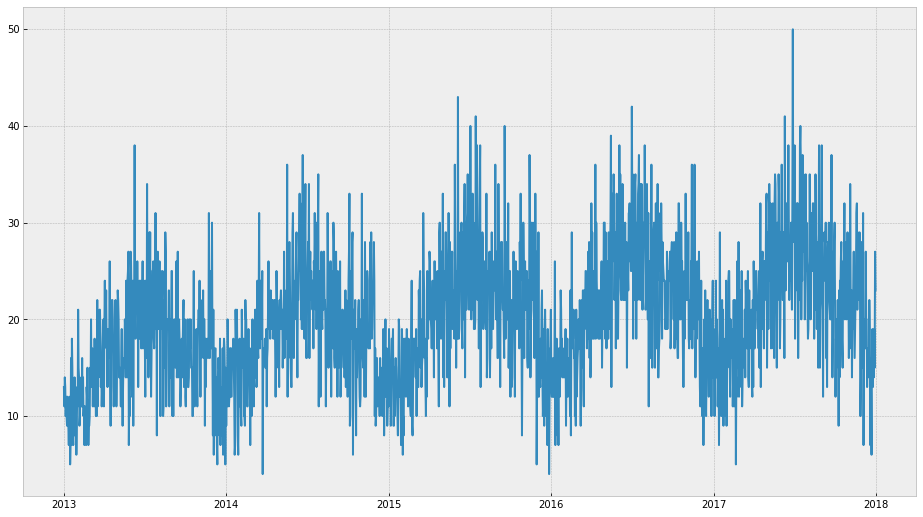

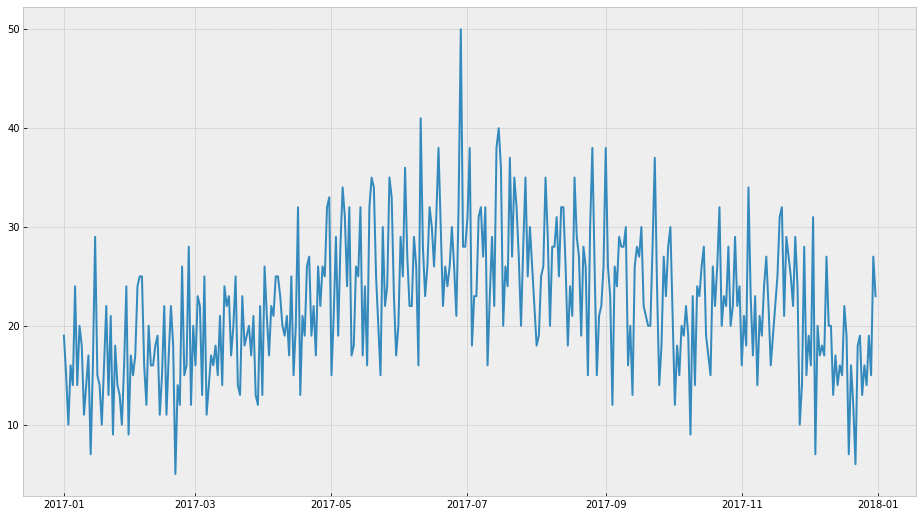

In [34]:
# Let's see what a time series looks like using matplotlib
store_1_item_1_time_series = data[data['store'].eq(1) & data['item'].eq(1)]['sales']
plt.plot(store_1_item_1_time_series)
plt.show()

# Last year
plt.plot(store_1_item_1_time_series.iloc[-365:])
plt.show()

# Clear seasonality patterns are evident in the graph, with peaks during the summer months
# The series is also characterized by a positive growth trend

,store,item,sales,day of week,day name
date,,,,,
2013-01-01,1,1,13,1,Tuesday
2013-01-02,1,1,11,2,Wednesday
2013-01-03,1,1,14,3,Thursday
2013-01-04,1,1,13,4,Friday
2013-01-05,1,1,10,5,Saturday


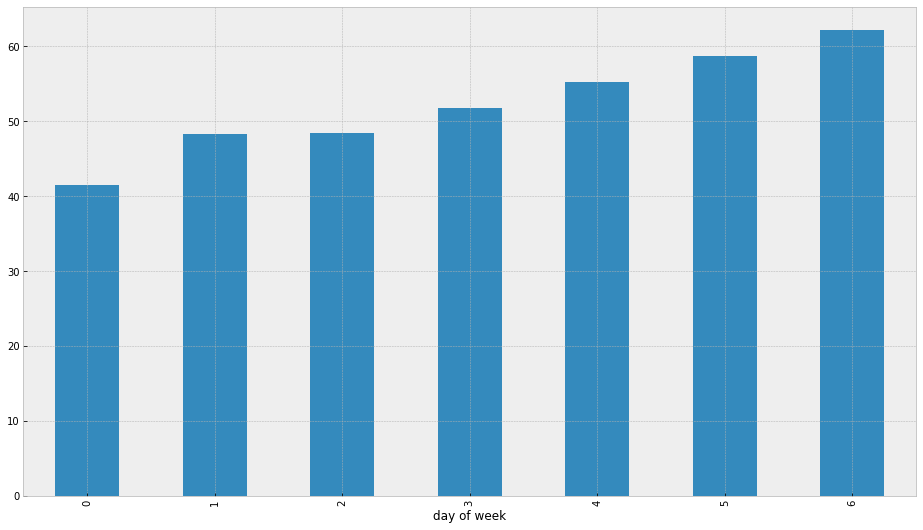

In [35]:
# Check whether weekly seasonality exists
data['day of week'] = data.index.dayofweek # add day of week column
data['day name'] = data.index.day_name()
display(data.head())
data.groupby('day of week')['sales'].mean().plot(kind='bar')
plt.show()
# Sales seem to be slighly larger during the weekends

# Drop the time period columns columns so we can later work on the original dataframe
data = data.drop(['day of week', 'day name'], axis=1) 

# Linear Regression

In [36]:
# In order to perform a linear regression on the seasonal components, we must first convert the data
# transforming categorical variables to dummy variables

def preprocess_series(series):
    data = pd.DataFrame()
    data['sales'] = series
    data['month'] = series.index.month # For monthly seasonality
    data['day_of_week'] = series.index.dayofweek # For weekly seasonality
    data['year'] = series.index.year # To account for trend
    # Convert seasonal variables to dummies
    data = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first=True)
    return data

In [37]:
# Check the output of a function
preprocessed_series = preprocess_series(store_1_item_1_time_series)
preprocessed_series.head()

,sales,year,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,
2013-01-01,13,2013,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2013-01-02,11,2013,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2013-01-03,14,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-04,13,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2013-01-05,10,2013,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [38]:
# I'll now define some data manipulation functions that will be useful during training

# In general, we will want to train the algorithm on roughly 70-90% of the data, and then evaluate
# the performance on the rest. We will take the last year of data to evaluate the algorithm performance

def get_training_and_test_data(data):
    train_data_index = (data.index < '2017-01-01')
    train_data = data.loc[train_data_index] 
    test_data = data.loc[~train_data_index] # Take the complement of the train set for the test set
    return train_data, test_data

In [39]:
# This function simply splits the datasets, returning one table with regressors, and a series with
# the target variable

def split_regressors_and_target_variables(data, target_variable='sales'):
    regressors = data.drop(target_variable, axis=1)
    target = data[target_variable]
    return regressors, target

In [40]:
# Now we're ready to train our first model!

train_data, test_data = get_training_and_test_data(preprocessed_series)
X_train, y_train = split_regressors_and_target_variables(train_data)
X_test, y_test = split_regressors_and_target_variables(test_data)

In [41]:
# Instantiate an ordinary least squares regression model
model = sm.OLS(y_train, X_train)
# Train the model
model = model.fit()
# Now you can get the predictions on the test set
predictions = model.predict(X_test)

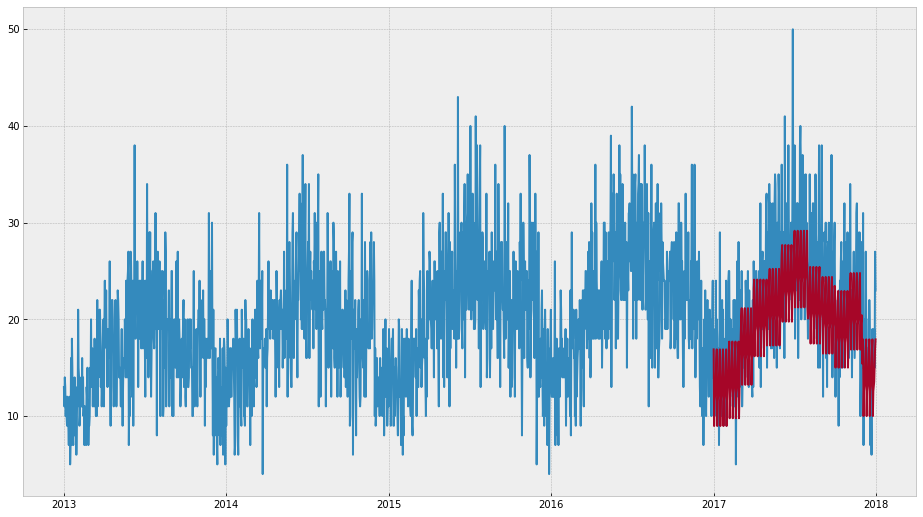

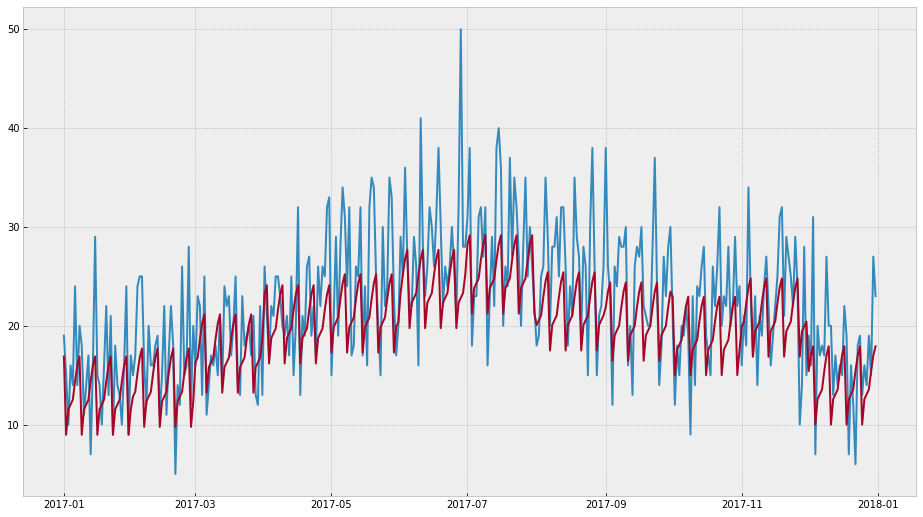

In [42]:
# Let's check how our model did on this example series with matplotlib
plt.plot(store_1_item_1_time_series)
plt.plot(predictions)
plt.show()

plt.plot(y_test)
plt.plot(predictions)
plt.show()

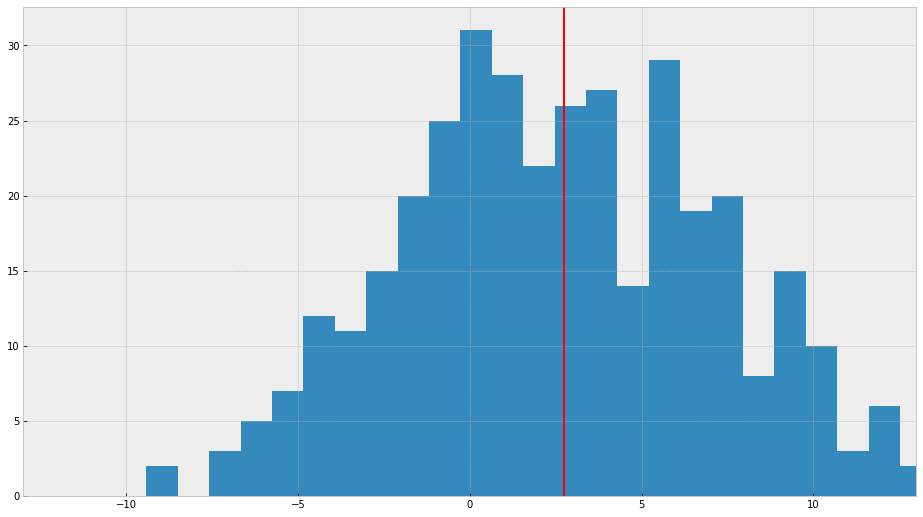

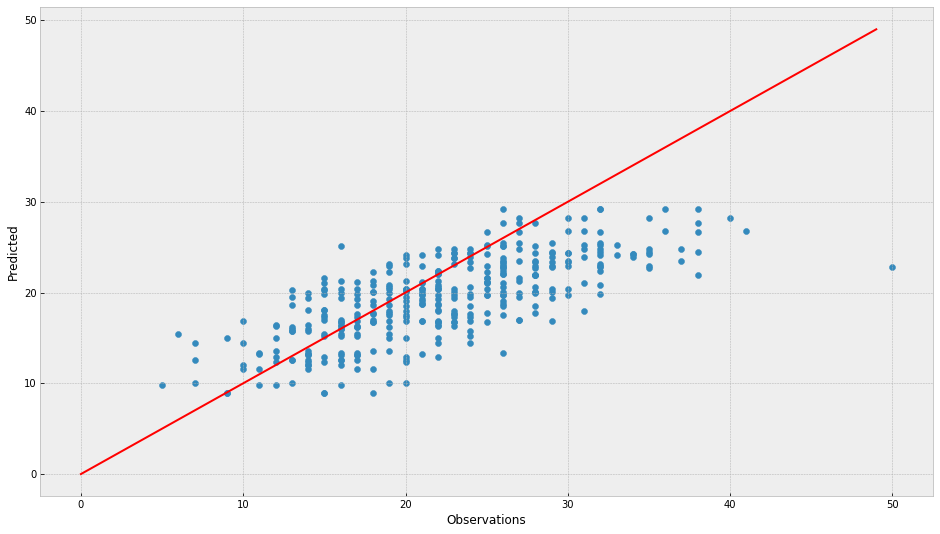

In [43]:
# It seems that in this particular case the model underestimated demand
# Let's check the error distribution
errors = y_test - predictions
mean_error = errors.mean()
plt.hist(errors, bins=40)
plt.xlim(-13, 13)
plt.axvline(mean_error, c='red')
plt.show()

# Let's see how predictions and observations are correlated
plt.scatter(y_test, predictions)
plt.xlabel('Observations')
plt.ylabel('Predicted')
plt.plot(list(range(50)), list(range(50)), color='red')
plt.show()

In [44]:
# We should calculate the Root Mean Squared Error (RMSE), in order to compare the performances 
# of each algorithm
def rmse(observations, predictions):
    return np.sqrt(np.square(observations - predictions).mean())

print(f'The RMSE was {rmse(y_test, predictions)}')

The RMSE was 5.536602770478944


In [45]:
# Good, now that we established the workflow for a single series, we should apply the algorithm to
# the whole dataset. We will be iterating through stores and items, performing a forecast 
# for each time series.
# We can take advantage of the pandas library group by function, but first let's wrap the whole
# training and prediction procedure in a single function:

def perform_linear_regression_forecast_on_series(series):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = sm.OLS(y_train, X_train)
    model = model.fit()
    predictions = model.predict(X_test)
    return predictions

In [46]:
%%time
# Let's apply the function to the dataset grouped by store and item
# Let's also time the algorithm, so we can later on evaluate how fast the algorithms were

result = (data.groupby(['store', 'item'])['sales']
              .apply(perform_linear_regression_forecast_on_series)
              .to_frame()
              .rename(columns={'sales': 'predicted'}))


Wall time: 11.8 s


In [47]:
result

predicted
store item date                 
1     1    2017-01-01  16.896689
           2017-01-02   8.971285
           2017-01-03  11.550655
           2017-01-04  12.050509
           2017-01-05  12.524238
...                          ...
10    50   2017-12-27  49.644798
           2017-12-28  54.296062
           2017-12-29  58.733136
           2017-12-30  63.144906
           2017-12-31  67.818274

[182500 rows x 1 columns]

In [48]:
# Merge with the original dataframe
forecast = data.merge(result, on=['date', 'store', 'item'])
forecast.head(10)

,store,item,sales,predicted
date,,,,
2017-01-01,1,1,19,16.896689
2017-01-02,1,1,15,8.971285
2017-01-03,1,1,10,11.550655
2017-01-04,1,1,16,12.050509
2017-01-05,1,1,14,12.524238
2017-01-06,1,1,24,14.390774
2017-01-07,1,1,14,15.972613
2017-01-08,1,1,20,16.896689
2017-01-09,1,1,18,8.971285


In [28]:
# Save the result in the /Results folder
forecast.to_csv('Results/Linear_Regression.csv')

In [50]:
# Let's evaluate the performance of the Linear Regression model over the whole test dataset
print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')

The overall RMSE was 12.076787816661742
The mean error was 8.138578542248561


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-02,2,15,231,161.113744,69.886256,69.886256
2017-07-05,8,15,193,126.800335,66.199665,66.199665
2017-08-20,2,18,201,136.993416,64.006584,64.006584
2017-07-16,9,28,195,131.651272,63.348728,63.348728
2017-07-16,9,18,187,124.625851,62.374149,62.374149
2017-06-02,8,15,192,129.896887,62.103113,62.103113
2017-06-17,3,13,185,123.558503,61.441497,61.441497
2017-07-01,8,28,204,145.974912,58.025088,58.025088
2017-08-25,2,10,165,107.133457,57.866543,57.866543


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-01-10,8,1,15,14.999514,0.000486,0.000486
2017-12-05,5,14,29,28.999594,0.000406,0.000406
2017-02-09,6,22,44,43.999633,0.000367,0.000367
2017-09-01,4,16,29,28.999681,0.000319,0.000319
2017-09-08,4,16,29,28.999681,0.000319,0.000319
2017-11-03,4,38,91,91.000289,-0.000289,0.000289
2017-08-21,2,41,25,24.999751,0.000249,0.000249
2017-03-15,1,33,51,51.000236,-0.000236,0.000236
2017-03-30,2,6,65,64.999827,0.000173,0.000173


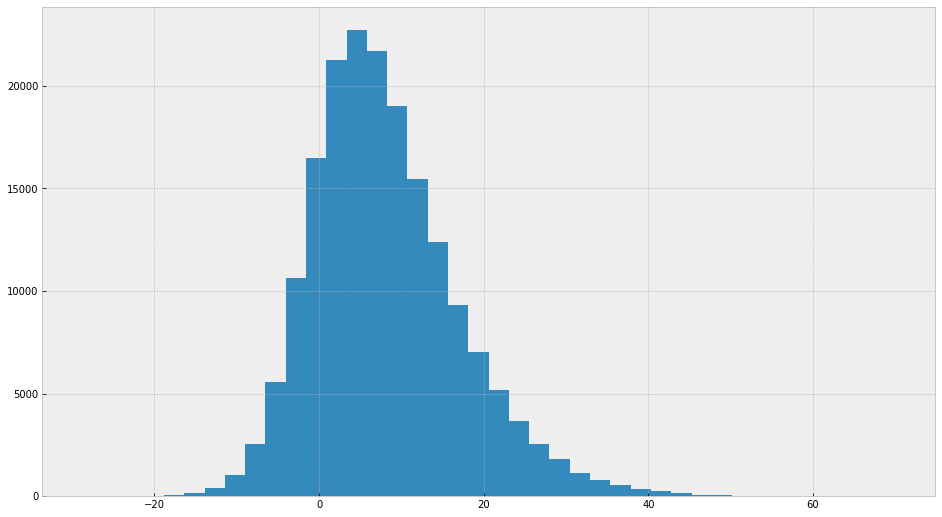

In [51]:
# It looks like the RMSE calculated over the test dataset was significantly higher than in the
# first example. It also looks like the forecast was too pessimistic, as sales tended to be higher
# than the predictions. Let's see where the algorithm was least (and most) accurate
forecast['error'] = forecast['sales'] - forecast['predicted']
forecast['absolute_error'] = np.abs(forecast['error'])
sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
display(sorted_by_abs_err.head(10))
display(sorted_by_abs_err.tail(10))

plt.hist(forecast['error'], bins=40)
plt.show()

In [91]:
# Let's define some functions to plot the best and worst predicted series

def plot_best_worst_series(forecast, n=4):
    # Sort all the series by their rmse, to find best and worst predicted
    sorted_by_error = (forecast.groupby(['store', 'item'])['error']
                           .std()
                           .reset_index()
                           .sort_values('error')
                           .rename(columns={'error': 'rmse'}))
    # Create a dictionary with the ids of the stores and items of the best/worst series
    top_predicted = sorted_by_error[['store', 'item']].head(n).to_dict(orient='records')
    bot_predicted = sorted_by_error[['store', 'item']].tail(n).to_dict(orient='records')
    # Display the series names, and plot the series
    print('Best predicted time series: ')
    display(sorted_by_error.head(n))
    plot_forecasts_from_data(forecast, top_predicted)
    print('Worst predicted time series: ')
    display(sorted_by_error.tail(n))
    plot_forecasts_from_data(forecast, bot_predicted)


def plot_forecasts_from_data(forecast, series_dicts):
    # I created this graphing function, since the commands were the same for plotting the best
    # and the worst series
    for series_info in series_dicts:
        temp = forecast[forecast['store'].eq(series_info['store']) &
                        forecast['item'].eq(series_info['item'])]
        plt.figure(figsize=(8, 6))
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.plot(temp['sales'])
        plt.plot(temp['predicted'])
        plt.legend()
        plt.show()

Best predicted time series: 


,store,item,rmse
250,6,1,3.836363
204,5,5,3.932919
303,7,4,4.089260
304,7,5,4.099541


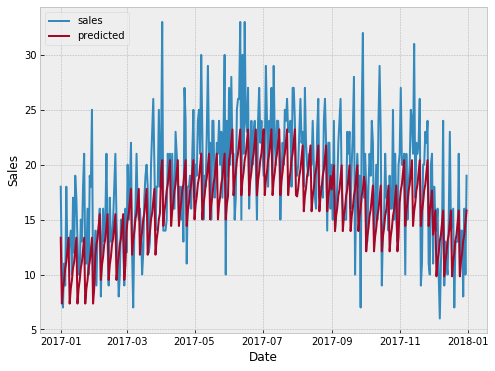

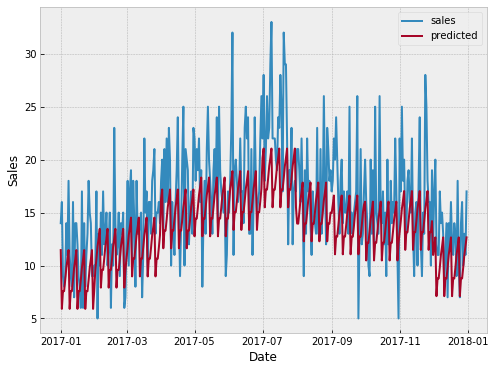

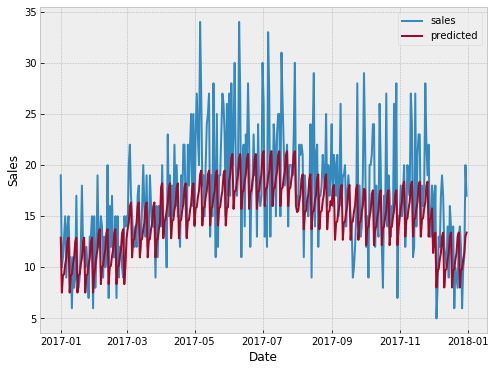

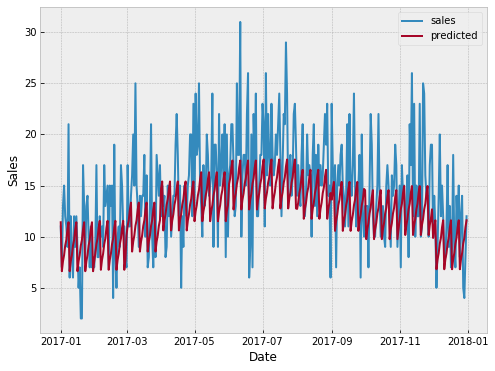

Worst predicted time series: 


,store,item,rmse
94,2,45,12.248379
77,2,28,12.305637
364,8,15,12.448777
67,2,18,12.973821


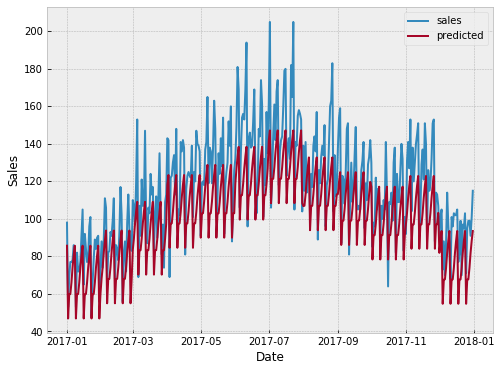

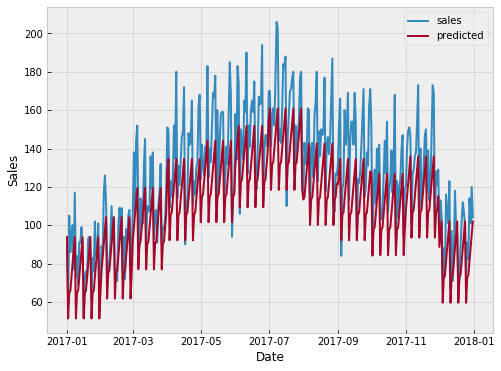

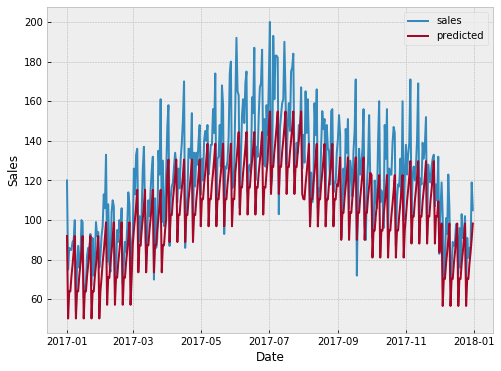

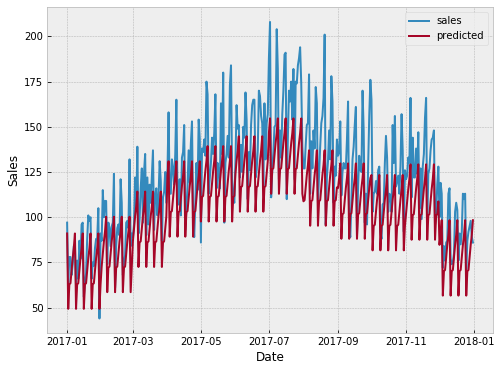

In [92]:
plot_best_worst_series(forecast)

In [95]:
# Since all of our models' outputs will be the same (date, store, item: prediction), we might 
# as well create a function to saves the results, and analyzes them.
# I also added a function for plotting errors and correlations

def plot_error_graphs(actual, predicted):
    errors = actual - predicted
    mean_error = errors.mean()
    plt.hist(errors, bins=40)
    plt.axvline(mean_error, c='red')
    plt.show()

    plt.scatter(actual, predicted)
    plt.xlabel('Observations')
    plt.ylabel('Predicted')
    line_length = actual.max()
    coordinates = list(range(line_length))
    plt.plot(x=coordinates, y=coordinates, color='red', alpha=0.5)
    plt.show()


def model_report(original_data, model_output, model_name, n_rows_to_display=10):
    forecast = original_data.merge(model_output, on=['date', 'store', 'item'])
    forecast.to_csv('Results/' + model_name + '.csv')
    forecast['error'] = forecast['sales'] - forecast['predicted']
    forecast['absolute_error'] = np.abs(forecast['error'])
    sorted_by_abs_err = forecast.sort_values('absolute_error', ascending=False)
    print('Most inaccurate')
    display(sorted_by_abs_err.head(n_rows_to_display))
    print('Most accurate')
    display(sorted_by_abs_err.tail(n_rows_to_display))
    print(f'The overall RMSE was {rmse(forecast.sales, forecast.predicted)}')
    print(f'The mean error was {(forecast.sales - forecast.predicted).mean()}')
    plot_error_graphs(forecast['sales'], forecast['predicted'])
    plot_best_worst_series(forecast)

# Random Forest

In [20]:
# Let's now apply the random forest regression algorithm. Luckily some of the steps to perform
# in order to apply this algorithm, are the same as for linear regression, and we can reuse some
# functions. We'll be using the same workflow as before, namely, group by, fit, forecast,
# combine results, and evaluate the model

def perform_rf_forecast_on_series(series):
    
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = RandomForestRegressor(n_estimators=100)
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test) # Prediction is a numpy.array
    predictions = pd.Series(data=predictions,
                            index=y_test.index,
                            name='sales') # Convert to a pandas series
    return predictions

# Since we are going to use this workflow many times, let's just create a function for our workflow
# So we don't have to type the same stuff over and over
def predict_all_series(data, function_to_apply):
    result = (data.groupby(['store', 'item'])['sales']
                  .apply(function_to_apply)
                  .to_frame()
                  .rename(columns={'sales': 'predicted'}))
    return result

In [35]:
%%time
rf_forecast = predict_all_series(data, perform_rf_forecast_on_series)

Wall time: 1min 46s


In [36]:
rf_forecast

predicted
store item date                 
1     1    2017-01-01  17.216794
           2017-01-02  10.374687
           2017-01-03  14.837008
           2017-01-04  13.041520
           2017-01-05  15.159401
...                          ...
10    50   2017-12-27  51.184619
           2017-12-28  60.252044
           2017-12-29  70.962115
           2017-12-30  70.433849
           2017-12-31  63.714357

[182500 rows x 1 columns]

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-08-20,2,18,201,144.723234,56.276766,56.276766
2017-06-02,8,15,192,138.875857,53.124143,53.124143
2017-11-10,10,15,154,101.811591,52.188409,52.188409
2017-07-05,8,15,193,142.120643,50.879357,50.879357
2017-07-30,3,8,178,129.764034,48.235966,48.235966
2017-11-12,3,11,139,90.770425,48.229575,48.229575
2017-06-17,2,2,150,101.905401,48.094599,48.094599
2017-08-27,2,45,183,135.618965,47.381035,47.381035
2017-03-10,8,8,131,84.075357,46.924643,46.924643


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-08,9,47,36,35.999623,0.000377,0.000377
2017-07-29,9,47,36,35.999623,0.000377,0.000377
2017-11-10,8,42,56,55.999647,0.000353,0.000353
2017-01-31,1,19,27,26.999651,0.000349,0.000349
2017-05-06,5,36,83,83.000343,-0.000343,0.000343
2017-10-18,8,11,80,79.999721,0.000279,0.000279
2017-01-08,7,32,29,28.999766,0.000234,0.000234
2017-02-28,10,46,49,49.000159,-0.000159,0.000159
2017-06-27,3,30,57,56.999869,0.000131,0.000131


The overall RMSE was 8.849885597337554
The mean error was 2.2420686972509873


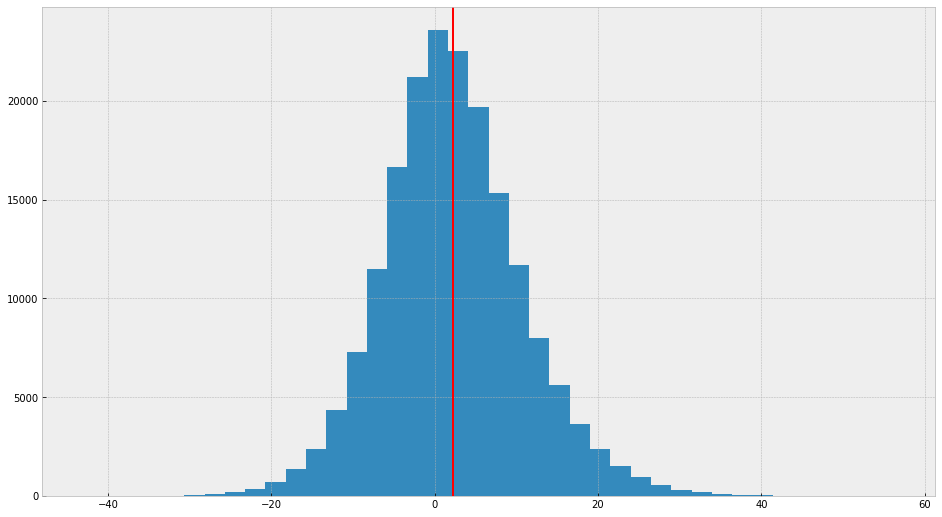

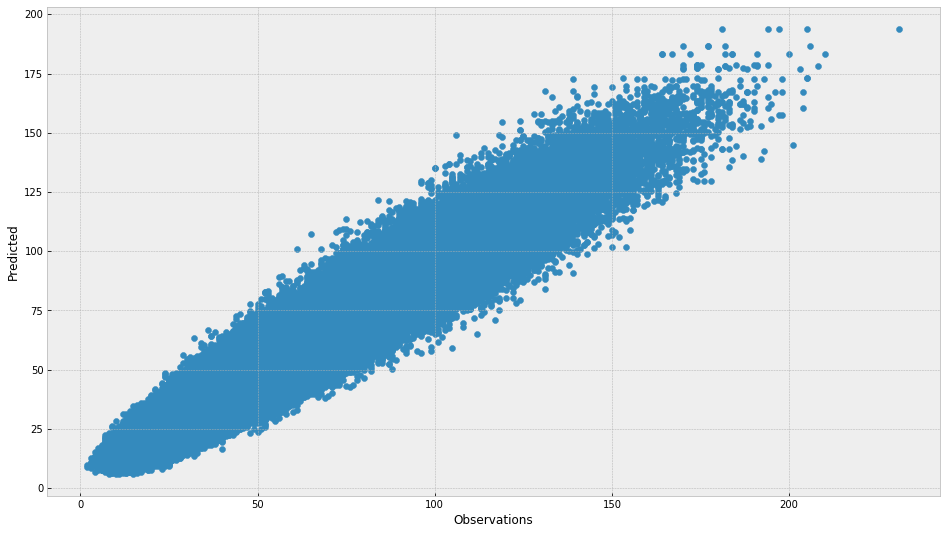

In [37]:
model_report(original_data=data,
             model_output=rf_forecast,
             model_name='RandomForest')

# ARIMA

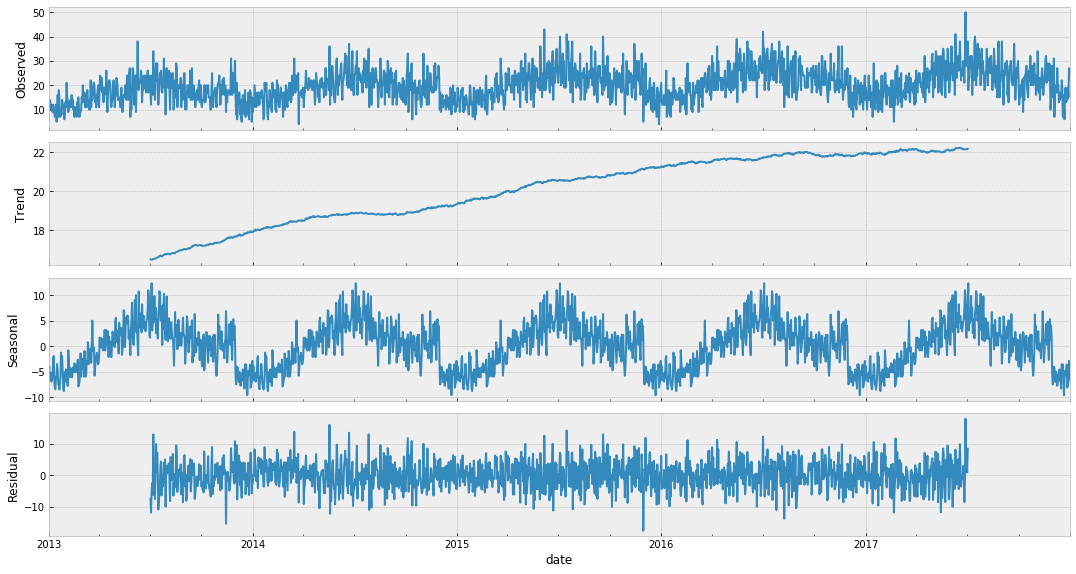

In [50]:
# First of all let's take a look at the seasonal trend decomposition of a single series
res = sm.tsa.seasonal_decompose(store_1_item_1_time_series, freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

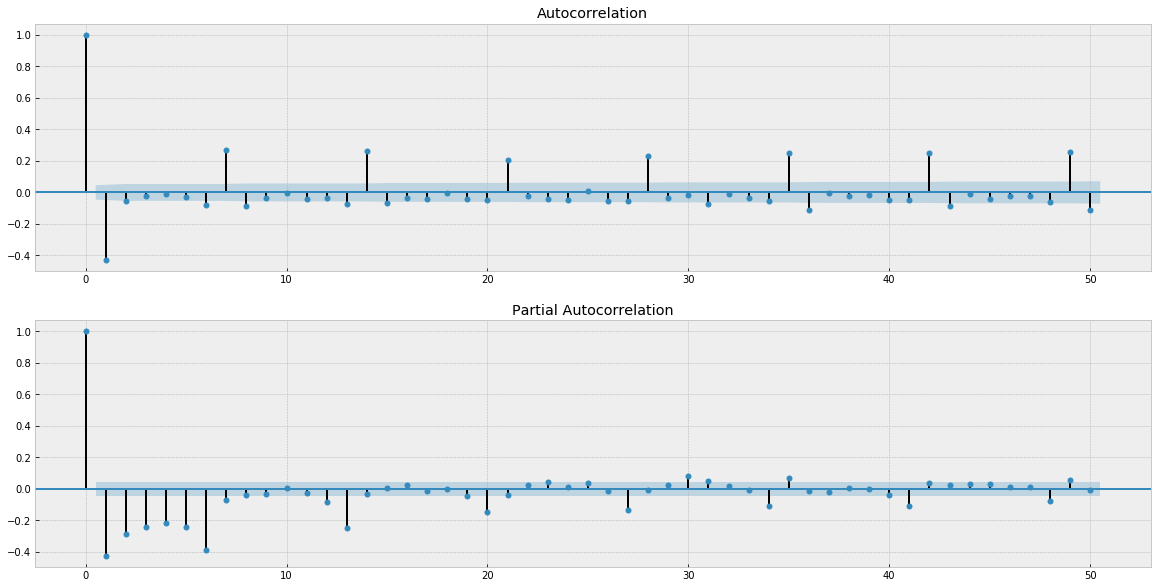

In [54]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(store_1_item_1_time_series.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(store_1_item_1_time_series.diff().dropna(), lags=50, ax=ax[1])
plt.show()

# From the autocorrelation plot, a weekly seasonality is noticeable

In [67]:
def perform_sarima_forecast_on_series(series):

    train_data, test_data = get_training_and_test_data(series)
    sarima = sm.tsa.statespace.SARIMAX(train_data,
                                       order=(7,1,7),
                                       seasonal_order=(1,0,5,1),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False,
                                       freq='D').fit()
    predictions = sarima.predict(start=test_data.index[0],
                                 end=test_data.index[-1])
    return predictions

In [68]:
%%time
sar_result = predict_all_series(data, perform_sarima_forecast_on_series)

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\dario.scanferlato\appdata\local\programs\python\python36\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users

Most inaccurate


,date,store,item,sales,predicted,error,absolute_error
51647,2017-07-02,2,15,231,114.295849,116.704151,116.704151
99103,2017-07-08,2,28,206,89.461873,116.538127,116.538127
62603,2017-07-08,2,18,204,89.803668,114.196332,114.196332
101286,2017-07-01,8,28,204,93.705409,110.294591,110.294591
51666,2017-07-21,2,15,198,89.582415,108.417585,108.417585
44354,2017-07-09,2,13,210,102.075706,107.924294,107.924294
51673,2017-07-28,2,15,197,89.461388,107.538612,107.538612
101666,2017-07-16,9,28,195,87.739620,107.260380,107.260380
65166,2017-07-16,9,18,187,80.084056,106.915944,106.915944
53807,2017-06-02,8,15,192,86.360562,105.639438,105.639438


Most accurate


,date,store,item,sales,predicted,error,absolute_error
47486,2017-02-06,1,14,33,32.997459,0.002541,0.002541
130304,2017-12-31,7,36,53,52.997906,0.002094,0.002094
31013,2017-12-20,5,9,29,28.997935,0.002065,0.002065
159178,2017-02-08,7,44,14,13.998004,0.001996,0.001996
71865,2017-11-22,7,20,25,25.001964,-0.001964,0.001964
105925,2017-03-17,1,30,33,33.001685,-0.001685,0.001685
58674,2017-10-02,1,17,23,22.998364,0.001636,0.001636
32132,2017-01-13,9,9,45,45.000571,-0.000571,0.000571
102576,2017-01-12,2,29,70,69.999789,0.000211,0.000211
160961,2017-12-28,1,45,54,54.000135,-0.000135,0.000135


The overall RMSE was 23.058344845364974
The mean error was 15.874839503786406


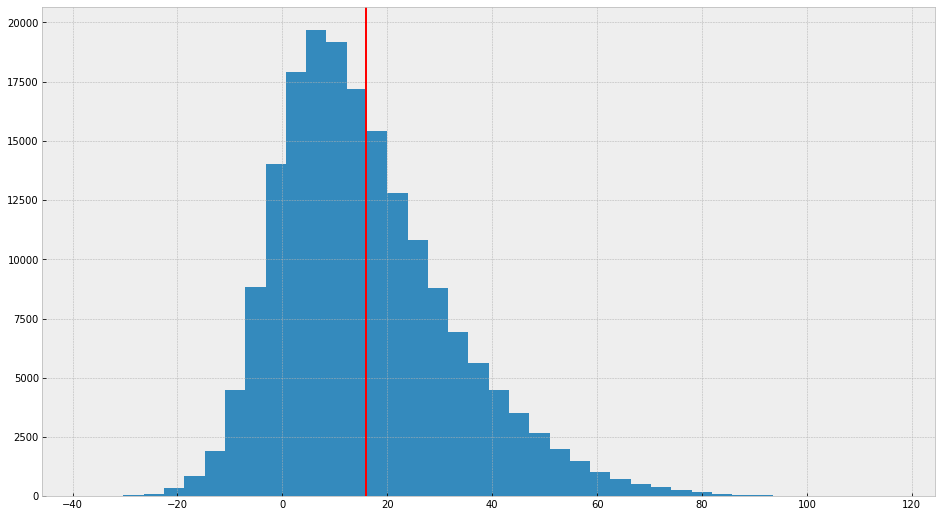

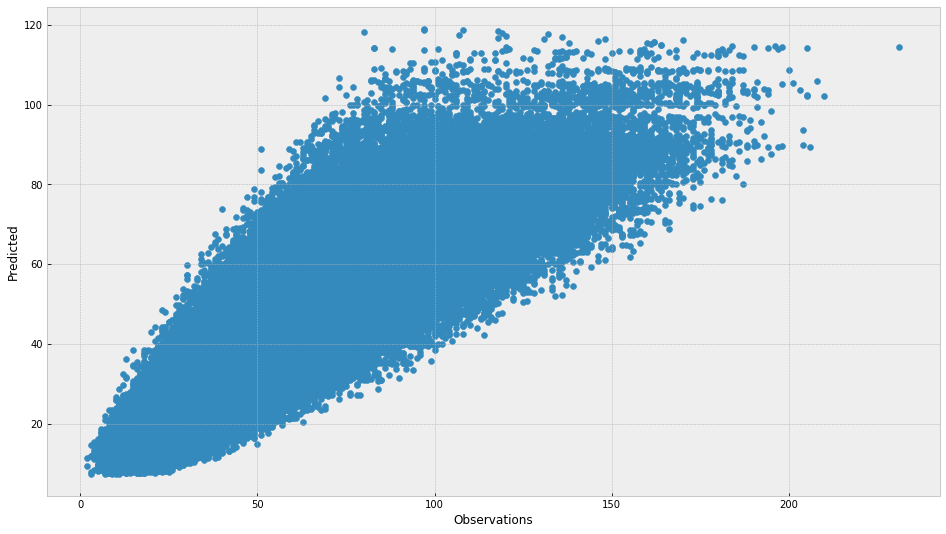

In [78]:
# Renaming the date column, because the statsmoels implementation for sarima is dumb
sar_result = sar_result.reset_index().rename(columns={'level_2': 'date'})
model_report(data, sar_result, model_name='Sarima')

# LightGBM (Gradient boosted trees) 

In [85]:
# Let's continue testing other models. A very strong candidate is LightGBM,an algorithm written
# by microsoft which was used to win many data science competitions on Kaggle.com 

def perform_lgb_forecast_on_series(series):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    model = lgb.LGBMRegressor()
    model = model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    predictions = pd.Series(data=predictions,
                        index=y_test.index,
                        name='sales') # Convert to a pandas series
    return predictions

In [86]:
%%time
lgb_forecast = predict_all_series(data, perform_lgb_forecast_on_series)

Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-05,8,15,193,139.608550,53.391450,53.391450
2017-06-02,8,15,192,138.666541,53.333459,53.333459
2017-07-02,2,15,231,178.929159,52.070841,52.070841
2017-08-20,2,18,201,153.718880,47.281120,47.281120
2017-06-17,3,13,185,137.865513,47.134487,47.134487
2017-07-16,9,18,187,140.779371,46.220629,46.220629
2017-09-16,2,38,173,127.369043,45.630957,45.630957
2017-05-23,8,22,152,106.457146,45.542854,45.542854
2017-04-02,8,33,155,110.141604,44.858396,44.858396


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-01-30,2,12,49,48.999607,0.000393,0.000393
2017-04-23,4,37,41,41.000372,-0.000372,0.000372
2017-10-10,8,10,89,88.999652,0.000348,0.000348
2017-08-28,6,39,33,33.000327,-0.000327,0.000327
2017-04-13,5,31,50,49.999870,0.000130,0.000130
2017-02-09,5,39,24,23.999902,0.000098,0.000098
2017-10-08,1,20,52,52.000095,-0.000095,0.000095
2017-10-05,3,14,73,72.999906,0.000094,0.000094
2017-02-12,10,42,42,41.999967,0.000033,0.000033


The overall RMSE was 8.454766278224952
The mean error was 2.1905778823034887


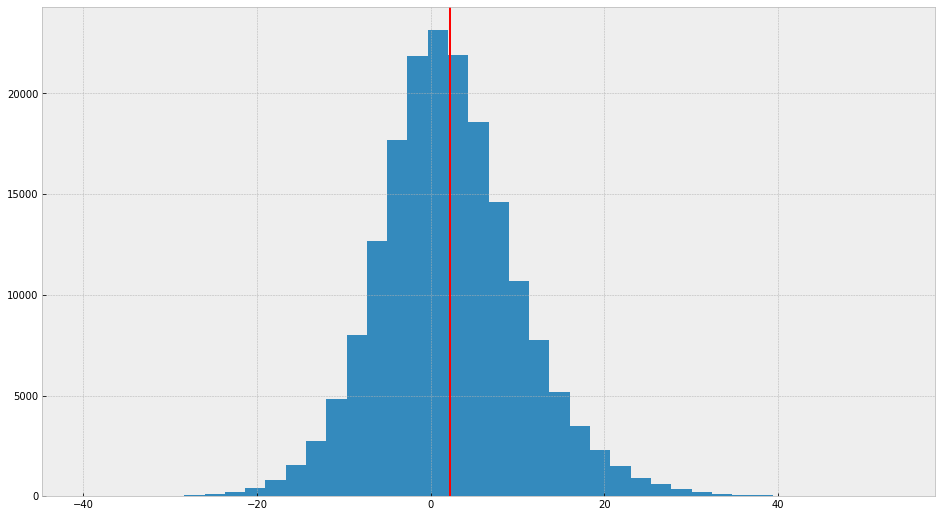

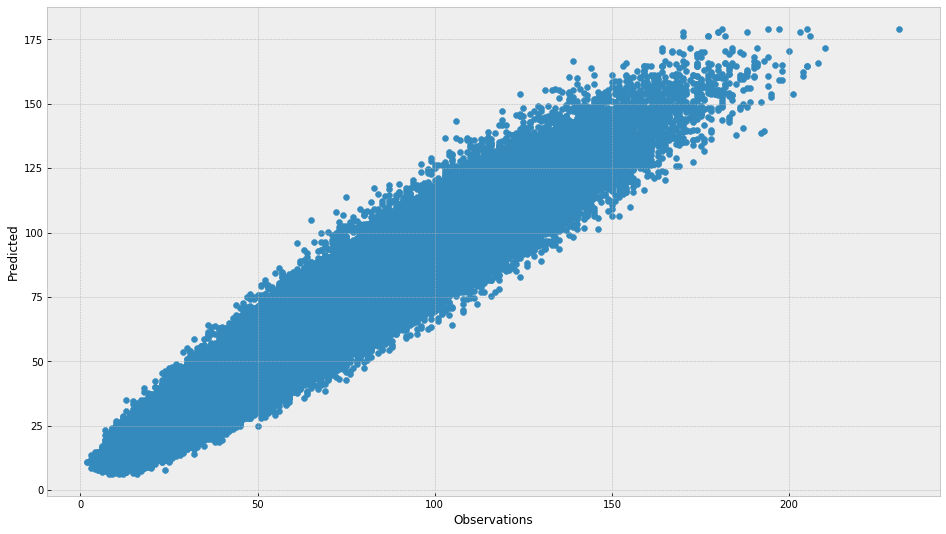

In [88]:
model_report(data, lgb_forecast, 'LightGBM')

# Deep Learning 

In [21]:
# Let's create a multi layer perceptron (MLP neural network) using PyTorch. PyTorch requires you to define a network as a class
# that inherits from the nn.Module class. We will create a neural network with two fully connected
# layers, and an output layer. We will also use ReLU activations functions for the neurons.

class MLPNet(nn.Module):  # Create a neural network, which inherits from the nn.Module
    
    def __init__(self, input_size, h1_neurons, h2_neurons):  # Here we define the network structure
        super(MLPNet, self).__init__()  # Initialize the nn.Module
        self.fc1 = nn.Linear(input_size, h1_neurons)  # First Layer
        self.fc2 = nn.Linear(h1_neurons, h2_neurons)  # Second Layer
        # Since the output is a single number, the output size is 1
        self.output_layer = nn.Linear(h2_neurons, 1)

    def forward(self, x):
        # Every class that inherits from nn.Module should have a forward function, which is
        # a list of operations to apply to the inputs in order to obtain the prediction
        x = F.relu(self.fc1(x))  # We use the ReLU function to introduce non-linearities in our network
        # Note that also other functions like the sigmoid, tanh, or ELU can be used
        x = F.relu(self.fc2(x))
        x = F.relu(self.output_layer(x))
        return x

In [22]:
# Deep learning libraries usually convert data to Tensor objects. Without getting too much into the
# details, this is done to make it easier to work with GPUs (even if we don't use a GPU we're still
# required to use tensors)

# Since PyTorch doesn't accept pandas DataFrame, let's convert everything to numpy ces first,
# using the .values method, then we convert the numpy 
nn_data_X = preprocessed_series.drop('sales', axis=1).values
nn_data_X = torch.Tensor(nn_data_X)

# VERY IMPORTANT: normalize the inputs to speed up convergence
nn_data_X = (nn_data_X - nn_data_X.mean(dim=0)) / nn_data_X.var(dim=0) 

nn_data_y = preprocessed_series['sales'].values
nn_data_y = torch.Tensor(nn_data_y)

# PyTorch requires your output to have an extra dimension to be in the same shape as the regressors
# Using .view(-1, 1) we add an extra dimension
print(nn_data_y)
nn_data_y = nn_data_y.view(-1, 1)
print(nn_data_y)
print(type(nn_data_X))

tensor([13., 11., 14.,  ..., 15., 27., 23.])
tensor([[13.],
        [11.],
        [14.],
        ...,
        [15.],
        [27.],
        [23.]])
<class 'torch.Tensor'>


In [23]:
n_features = nn_data_X.shape[1]  # Check the number of regressor (18)

In [24]:
# Now the tricky part

# First we instantiate a neural network with 2 hidden layers of 8 and 4 neurons
net = MLPNet(input_size=n_features,
              h1_neurons=8, h2_neurons=4)
# Then we define an optimizer to train our neural network. In this case we're using Stochastic Gradient
# Descent as a simple example
optimizer = opt.SGD(net.parameters(), lr=0.01)
# Then we define a loss function that we want to minimize. In this case we use RMSE
criterion = nn.MSELoss()
epochs = 1000  # Number of training iterations

In [25]:
losses = np.zeros(epochs)  # Create an array where we keep track of the loss function
for i in range(epochs):
    optimizer.zero_grad()  # In each iteration we set the gradients to 0
    # For more info check https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

    predictions = net(nn_data_X)  # Get the predictions. Using net as a function just calls the
                                  # forward method of our MLPNet
    loss = criterion(predictions, nn_data_y)  # Calculate the loss
    loss.backward()  # Calculate the gradients of the loss function with respect to the net parameters
    optimizer.step()  # Update Network parameters
    losses[i] = loss.item()
    if i % 100 == 0:
        print(loss.item())

442.9783935546875
21.052762985229492
19.144609451293945
18.54761505126953
18.361560821533203
18.287914276123047
18.265060424804688
18.255779266357422
18.251270294189453
18.24835205078125


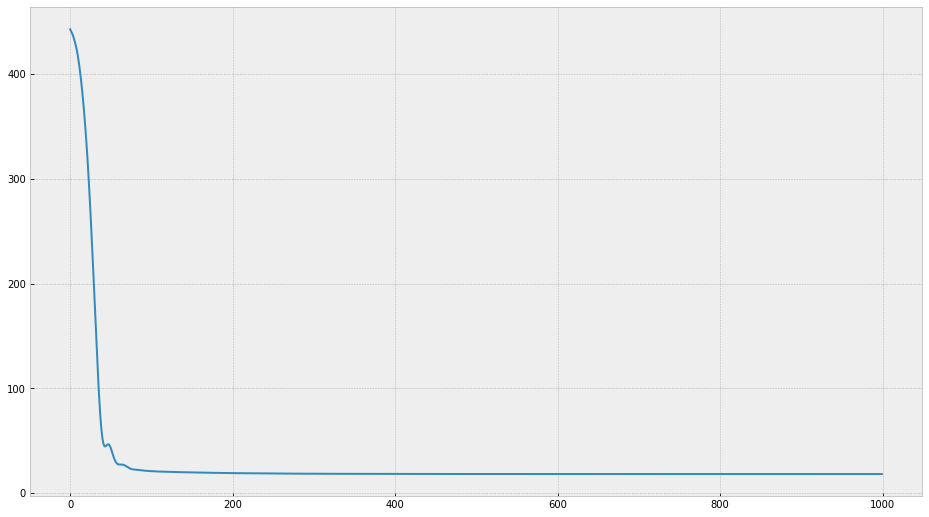

In [26]:
# Let's plot the loss function during training, to ensure the optimization was carried out successfully
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.show()

In [97]:
# Now let's wrap everything into a function
def perform_mlp_forecast_on_series(series, epochs=300, lr=0.01, h1_neurons=4, h2_neurons=2):
    series = preprocess_series(series)
    train_data, test_data = get_training_and_test_data(series)
    X_train, y_train = split_regressors_and_target_variables(train_data)
    X_test, y_test = split_regressors_and_target_variables(test_data)
    # Save the dates before converting to tensor!
    dates = y_test.index
    
    # Convert to tensor
    X_train = torch.Tensor(X_train.values)
    X_test = torch.Tensor(X_test.values)
    # Also add a dimension to observations
    y_train = torch.Tensor(y_train.values).view(-1, 1)
    y_test = torch.Tensor(y_test.values).view(-1, 1)
    
    # Normalize
    input_mean = X_train.mean(dim=0)
    input_var = X_train.var(dim=0)
    
    X_train = (X_train - input_mean) / input_var
    X_test = (X_test - input_mean) / input_var # Note that we normalize test using the
                                               # mean and var of the training data
    
    # Instantiate network, optimizer, and loss function
    net = MLPNet(input_size=X_train.shape[1],
                 h1_neurons=h1_neurons, h2_neurons=h2_neurons)
    optimizer = opt.Adam(net.parameters(), lr=lr)  # This time let's use the Adam optimizer which is faster
    criterion = nn.MSELoss()
    
    # Training
    for i in range(epochs):
        optimizer.zero_grad()
        predictions = net(X_train) 
        loss = criterion(predictions, y_train) 
        loss.backward()
        optimizer.step()
    
    # Convert back to pandas series
    predictions = net(X_test)
    predictions = predictions.detach() # Detatch gradient or Pytorch will say it can't convert to numpy
    predictions = predictions.numpy().flatten()  # Convert to numpy array and flatten again
    predictions = pd.Series(data=predictions,
                        index=dates,
                        name='sales') # Convert to a pandas series
    return predictions

In [98]:
%%time
mlp_forecast = predict_all_series(data, perform_mlp_forecast_on_series)

Wall time: 4min 27s


Most inaccurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-07-08,2,28,206,0.0,206.0,206.0
2017-07-09,2,28,203,0.0,203.0,203.0
2017-07-02,8,15,200,0.0,200.0,200.0
2017-07-16,9,28,195,0.0,195.0,195.0
2017-06-25,2,28,194,0.0,194.0,194.0
2017-07-05,8,15,193,0.0,193.0,193.0
2017-07-16,2,25,193,0.0,193.0,193.0
2017-06-02,8,15,192,0.0,192.0,192.0
2017-07-30,2,25,190,0.0,190.0,190.0


Most accurate


,store,item,sales,predicted,error,absolute_error
date,,,,,,
2017-08-05,7,33,70,70.001030,-0.001030,0.001030
2017-02-06,1,12,41,40.999077,0.000923,0.000923
2017-02-16,8,26,45,45.000862,-0.000862,0.000862
2017-12-14,8,39,49,49.000782,-0.000782,0.000782
2017-08-31,2,31,103,103.000618,-0.000618,0.000618
2017-07-17,4,27,29,29.000418,-0.000418,0.000418
2017-08-19,6,5,19,19.000156,-0.000156,0.000156
2017-07-18,2,18,144,144.000107,-0.000107,0.000107
2017-03-23,3,19,48,48.000031,-0.000031,0.000031


The overall RMSE was 44.27817153930664
The mean error was 23.769485473632812


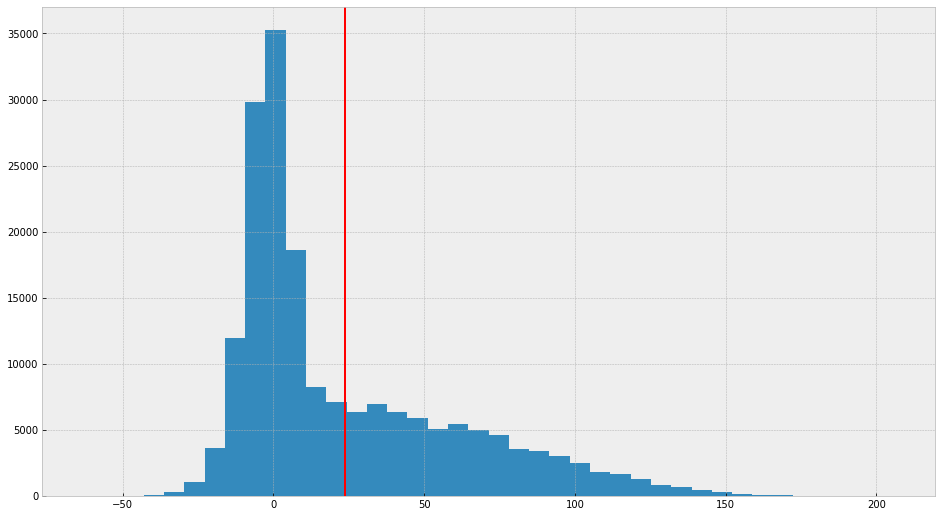

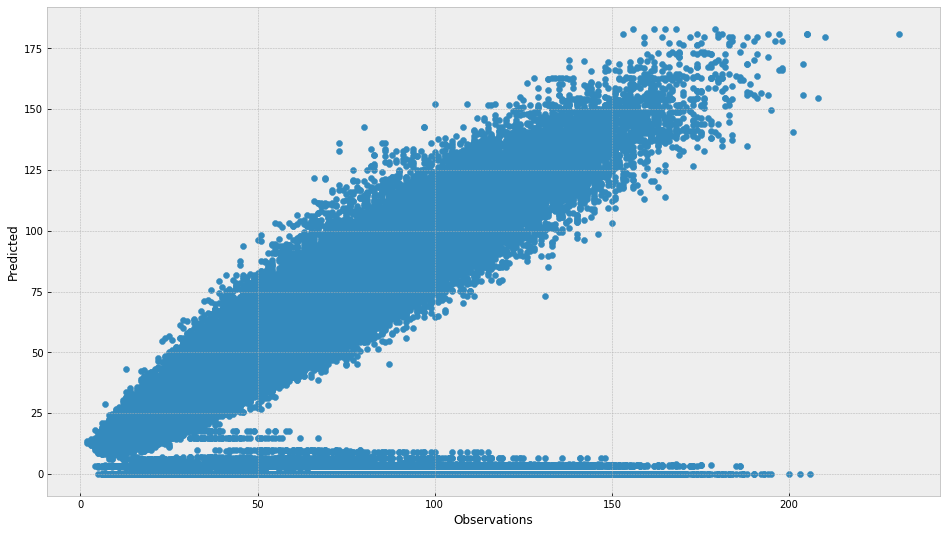

Best predicted time series: 


,store,item,rmse
204,5,5,4.022786
303,7,4,4.132356
346,7,47,4.236084
254,6,5,4.314617


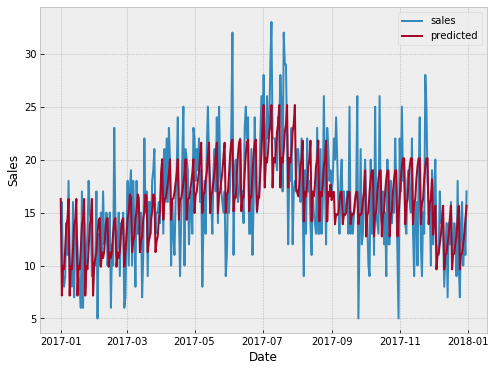

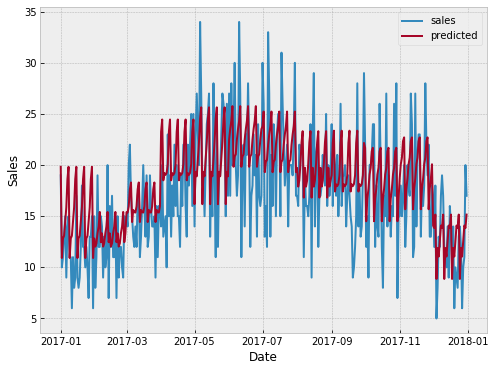

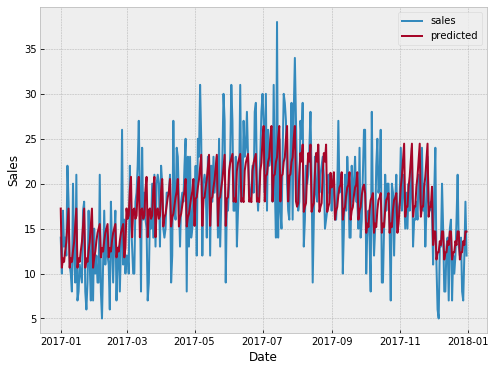

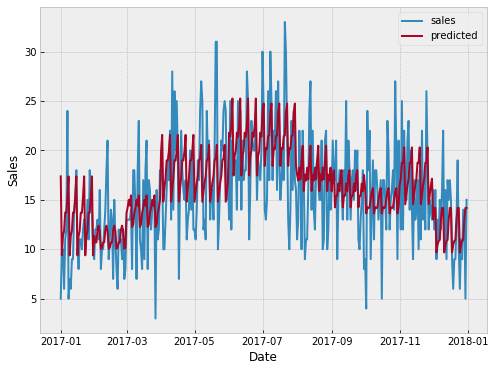

Worst predicted time series: 


,store,item,rmse
380,8,31,30.450565
77,2,28,30.682304
84,2,35,34.090496
137,3,38,43.595840


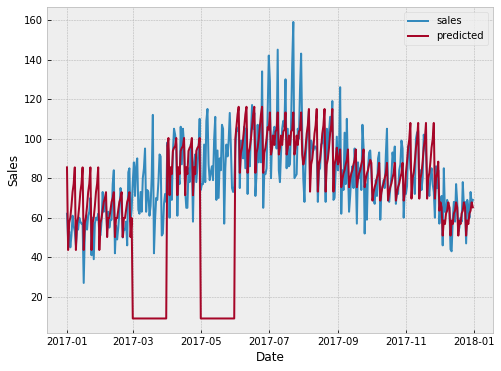

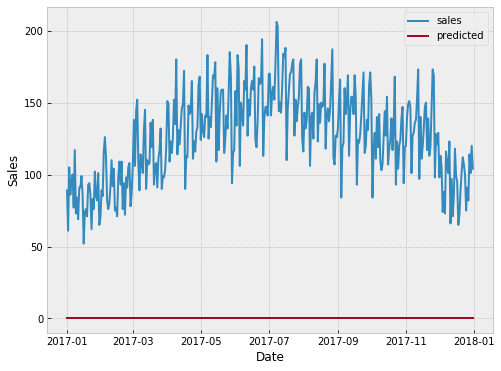

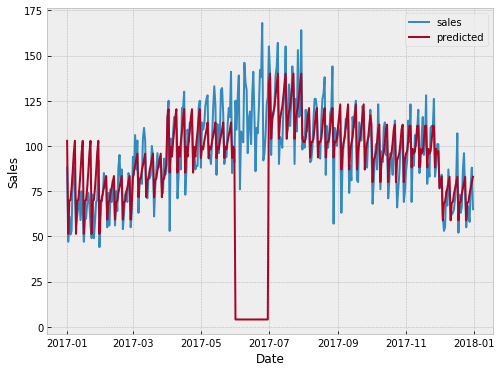

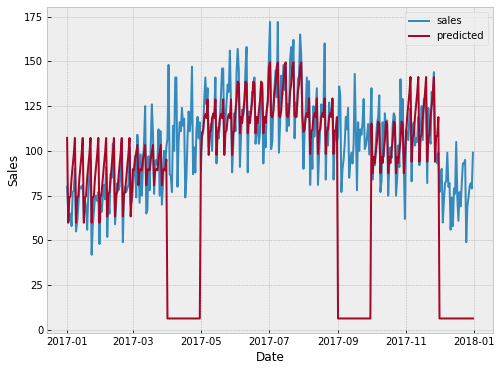

In [99]:
model_report(data, mlp_forecast, 'NeuralNetwork')